In [31]:
import pandas as pd
from datetime import date, timedelta
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA

In [2]:
price_demand = pd.read_pickle('new_price_demand.pkl')
weather = pd.read_pickle('new_weather.pkl')

In [3]:
# Group the price_demand data by Date. Only keep the rows has max TOTALDEMAND of the Date.
max_price_demand = price_demand.loc[price_demand.groupby('DATE')['TOTALDEMAND'].idxmax()]

# Merge the datasets
merged_data = pd.merge(max_price_demand, weather, left_on='DATE', right_on='Date', how='inner')
merged_data = merged_data[['DATE', 'TIME', 'MONTH',
 'Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)','Evaporation (mm)', 'Sunshine (hours)', 'Direction of maximum wind gust ',
 'Speed of maximum wind gust (km/h)', 'Time of maximum wind gust',
 '9am Temperature (°C)', '9am relative humidity (%)',
 '9am cloud amount (oktas)', '9am wind direction',
 '9am wind speed (km/h)', '9am MSL pressure (hPa)',
 '3pm Temperature (°C)', '3pm relative humidity (%)',
 '3pm cloud amount (oktas)', '3pm wind direction', '3pm wind speed (km/h)',
 '3pm MSL pressure (hPa)',  'TOTALDEMAND', 'PRICECATEGORY',]]


In [4]:
# Merge the datasets
test_data = pd.merge(max_price_demand, weather, left_on='DATE', right_on='Date', how='inner')
test_data = merged_data[['DATE', 'TIME', 'MONTH',
 'Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)','Evaporation (mm)', 'Sunshine (hours)', 'Direction of maximum wind gust ',
 'Speed of maximum wind gust (km/h)', 'Time of maximum wind gust',
 '9am Temperature (°C)', '9am relative humidity (%)',
 '9am cloud amount (oktas)', '9am wind direction',
 '9am wind speed (km/h)', '9am MSL pressure (hPa)',
 '3pm Temperature (°C)', '3pm relative humidity (%)',
 '3pm cloud amount (oktas)', '3pm wind direction', '3pm wind speed (km/h)',
 '3pm MSL pressure (hPa)',  'TOTALDEMAND', 'PRICECATEGORY',]]

In [15]:
classlabel = 'TOTALDEMAND'
demand_bin = 'DEMAND_BIN'

categorical_features = ['Direction of maximum wind gust ', 'Time of maximum wind gust', '9am wind direction', '3pm wind direction', 'MONTH']

continuous_features = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)', 
'Speed of maximum wind gust (km/h)', 
'9am Temperature (°C)', '9am relative humidity (%)', 
'9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)', '3pm Temperature (°C)', '3pm relative humidity (%)', '3pm cloud amount (oktas)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)']

temperature_features = ['Minimum temperature (°C)', 'Maximum temperature (°C)', '9am Temperature (°C)','3pm Temperature (°C)']

all_numeric_features = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Sunshine (hours)', 
'Speed of maximum wind gust (km/h)', 
'9am Temperature (°C)', '9am relative humidity (%)', 
'9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)', '3pm Temperature (°C)', '3pm relative humidity (%)', '3pm cloud amount (oktas)', '3pm wind speed (km/h)', '3pm MSL pressure (hPa)', 'MONTH']

random_state_list = [1, 7, 11, 49, 61]

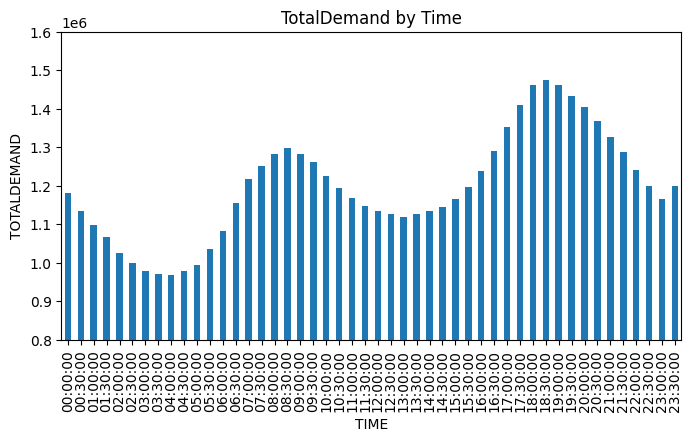

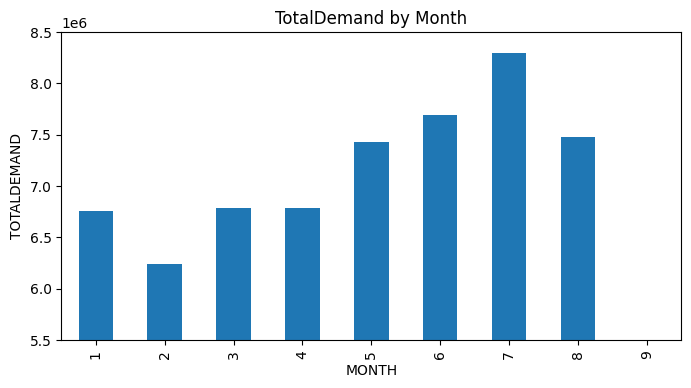

In [4]:
# Group price_demand data by TIME, to find out the correlation between energy consumption and time of the day.
price_demand_by_time = price_demand.groupby('TIME').sum('TOTALDEMAND')
plt.figure(figsize=(8, 4))
price_demand_by_time['TOTALDEMAND'].plot(kind='bar')
plt.xlabel('TIME')
plt.ylabel('TOTALDEMAND')
plt.ylim(0.8e6, 1.6e6)
plt.title('TotalDemand by Time')
plt.show()

# Group price_demand data by MONTH, to get the correlation between energy consumption and MONTH.
price_demand_by_month = price_demand.groupby('MONTH').sum('TOTALDEMAND')
plt.figure(figsize=(8, 4))
price_demand_by_month['TOTALDEMAND'].plot(kind='bar')
plt.xlabel('MONTH')
plt.ylabel('TOTALDEMAND')
plt.ylim(5.5e6, 8.5e6)
plt.title('TotalDemand by Month')
plt.show()

In [5]:
display(merged_data['TOTALDEMAND'].describe())
display(merged_data.head(10))

count     243.000000
mean     6138.343663
std       816.139421
min      4473.050000
25%      5507.765000
50%      6234.670000
75%      6763.515000
max      8196.830000
Name: TOTALDEMAND, dtype: float64

,DATE,TIME,MONTH,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),...,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND,PRICECATEGORY
0,2021-01-01,17:30:00,1,15.6,29.9,0.0,2.8,9.3,NNE,31,...,2,1018.8,28.1,43,5,E,13,1015.3,5019.64,LOW
1,2021-01-02,17:00:00,1,18.4,29.0,0.0,9.4,1.3,NNW,30,...,17,1013.3,28.7,38,7,SW,4,1008.5,4964.35,LOW
2,2021-01-03,18:30:00,1,17.0,26.2,12.6,4.8,7.1,WSW,33,...,4,1007.7,23.5,59,4,SSW,2,1005.2,4503.31,LOW
3,2021-01-04,18:30:00,1,16.0,18.6,2.6,3.8,0.0,SSE,41,...,11,1010.0,18.2,82,8,SSW,17,1011.0,4764.18,LOW
4,2021-01-05,17:00:00,1,15.9,19.1,11.2,1.0,0.0,SSE,35,...,13,1012.5,18.2,82,8,SSE,19,1013.3,4800.64,LOW
5,2021-01-06,19:30:00,1,13.7,19.2,1.2,1.0,3.2,S,35,...,11,1020.0,18.1,63,7,SSW,17,1020.0,4691.13,LOW
6,2021-01-07,19:00:00,1,14.7,25.7,0.0,3.6,12.1,SSE,44,...,13,1023.9,24.3,46,4,SSE,20,1022.0,4994.78,LOW
7,2021-01-08,18:30:00,1,12.7,24.3,0.0,9.8,13.1,SSW,31,...,6,1024.8,23.1,53,1,SSW,11,1022.2,5365.19,LOW
8,2021-01-09,18:30:00,1,14.2,27.9,0.0,7.0,12.9,NNW,30,...,11,1022.0,24.4,59,2,SSW,11,1019.3,5863.37,MEDIUM
9,2021-01-10,18:30:00,1,16.9,33.5,0.0,8.0,9.6,E,24,...,6,1020.4,26.7,60,1,SW,11,1015.9,6859.02,MEDIUM


In [7]:
# Applying bins to TOTALDEMAND
def bin_demand(x, bin_list):
    """
    Domain knowledge oriented discretization using bins
    """
    for i in range(len(bin_list)):
        if x < bin_list[i]: # [min, 5500)
            return int(i+1)

# apply the function on the series
bin_list = [5500, 6500, 7000, 7500, 8200]
merged_data['DEMAND_BIN'] = merged_data['TOTALDEMAND'].apply(lambda x: bin_demand(x,bin_list=bin_list)).astype(int)



Analyze and find the factors that are most correlated with daily maximum energy consumption.

Methods used:
1. Seasonality analysis
2. Pearson correlation analysis
3. Mutual information analysis
4. Entropy value analysis

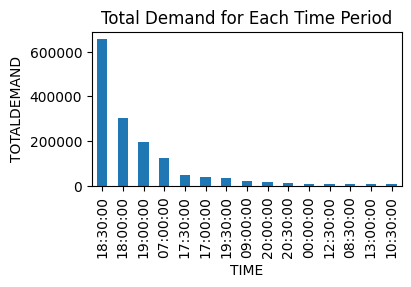

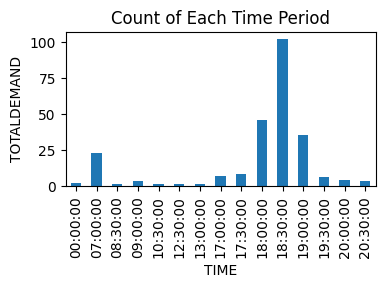

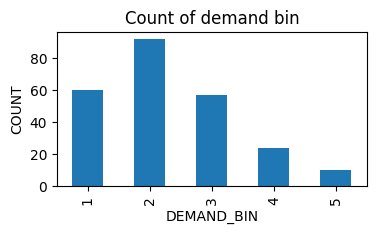

In [8]:
# To show which time period consumes the most energy throughout a day
grouped_demand_by_time = merged_data.groupby('TIME').sum('TOTALDEMAND')
sorted_demand_by_time = grouped_demand_by_time.sort_values(by='TOTALDEMAND', ascending=False)

plt.figure(figsize=(4, 2))
sorted_demand_by_time['TOTALDEMAND'].plot(kind='bar')
plt.xlabel('TIME')
plt.ylabel('TOTALDEMAND')
plt.title('Total Demand for Each Time Period')
plt.show()

freq_demand_by_time = merged_data.groupby('TIME').count()
plt.figure(figsize=(4, 2))
freq_demand_by_time['TOTALDEMAND'].plot(kind='bar')
plt.xlabel('TIME')
plt.ylabel('TOTALDEMAND')
plt.title('Count of Each Time Period')
plt.show()

time_demand_by_bin = merged_data.groupby('DEMAND_BIN').count()
plt.figure(figsize=(4, 2))
time_demand_by_bin['TOTALDEMAND'].plot(kind='bar')
plt.xlabel('DEMAND_BIN')
plt.ylabel('COUNT')
plt.title('Count of demand bin')
plt.show()

In [9]:
max_daily_corr = weather.corrwith(max_price_demand['TOTALDEMAND'], method='pearson')
max_daily_corr = max_daily_corr.sort_values(ascending=False)

display(max_daily_corr)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6124\3872966214.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_daily_corr = weather.corrwith(max_price_demand['TOTALDEMAND'], method='pearson')


3pm Temperature (°C)                 0.883158
Maximum temperature (°C)             0.746063
Minimum temperature (°C)             0.662852
3pm wind speed (km/h)                0.607783
9am relative humidity (%)            0.572600
9am Temperature (°C)                 0.545737
Evaporation (mm)                     0.506157
Rainfall (mm)                        0.424934
9am cloud amount (oktas)             0.126290
Sunshine (hours)                     0.095171
3pm cloud amount (oktas)            -0.008839
Speed of maximum wind gust (km/h)   -0.102942
9am MSL pressure (hPa)              -0.345800
3pm MSL pressure (hPa)              -0.432511
Month                               -0.522853
3pm relative humidity (%)           -0.606512
9am wind speed (km/h)               -0.908040
dtype: float64

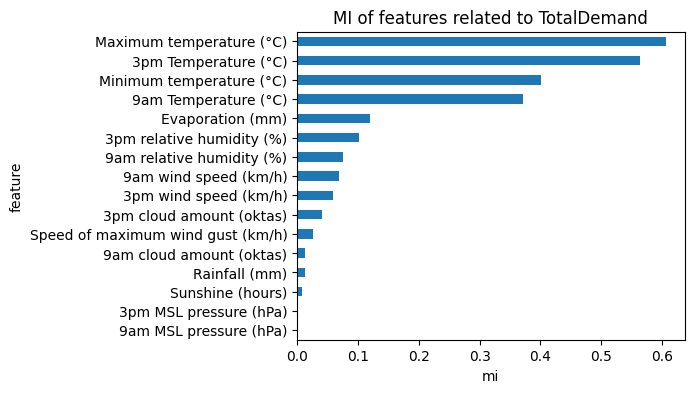

In [32]:
X = merged_data['TOTALDEMAND'].values.reshape(-1, 1)
mi_list = []
for feature in continuous_features:
    Y = merged_data[feature].values
    mi = mutual_info_regression(X, Y)
    mi_list.append(mi[0])

nmi_frame = pd.DataFrame(list(zip(continuous_features, mi_list)), columns= ['feature', 'mi']).set_index('feature')
nmi_frame = nmi_frame.sort_values('mi', ascending=True)

plt.figure(figsize=(5, 4))
nmi_frame['mi'].plot(kind='barh')
plt.xlabel('mi')
plt.ylabel('feature')
plt.title('MI of features related to TotalDemand')
plt.show()


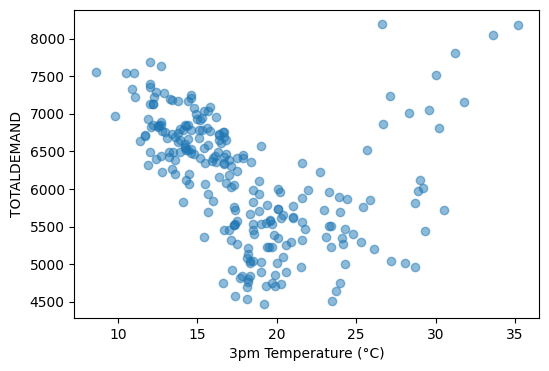

In [36]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(merged_data['3pm Temperature (°C)'], merged_data['TOTALDEMAND'], alpha=0.5)
plt.xlabel('3pm Temperature (°C)')
plt.ylabel('TOTALDEMAND')
plt.show()

In [29]:
def my_entropy(probs):   
    return -probs.dot(np.log2(probs))


entropy = []
for (col_name, value) in max_daily_corr.items():
    if col_name == "Month":
        break
    e = my_entropy(merged_data[col_name].value_counts(normalize=True, sort=False))
    entropy.append((col_name, e))

entropy = pd.Series(sorted(entropy, key=lambda x: x[1], reverse=True))
print(entropy)


0           (3pm MSL pressure (hPa), 7.143686834765759)
1           (9am MSL pressure (hPa), 7.071469242084136)
2         (Maximum temperature (°C), 6.816592417253974)
3             (3pm Temperature (°C), 6.782170491424344)
4         (Minimum temperature (°C), 6.725008699605699)
5             (9am Temperature (°C), 6.723307271161799)
6                 (Sunshine (hours), 6.537113392569879)
7        (9am relative humidity (%), 5.442774195117113)
8                 (Evaporation (mm), 5.352978114441177)
9     (Speed of maximum wind gust (km/h), 4.45528476...
10           (3pm wind speed (km/h), 3.688070388861302)
11                   (Rainfall (mm), 2.876001111163461)
12       (3pm cloud amount (oktas), 2.5622025753892554)
13        (9am cloud amount (oktas), 2.417411653526932)
dtype: object


## Kfold Linear Regression Model ##

In [39]:
# Linear Regression Model

def lr_kfold_accuracy_score (k_fold, dataset, features, classlabel, randmonStateList):
    '''Our goal is get a list of r2 scores for each fold which
    we could average out to get an average r2 score'''
    #here we provide a fixed int for random_state to ensure it has the same seed
    #every time
    r2_scores=[]
    for randomState in randmonStateList:
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=randomState)
        #starting another loop here for our kfold
        for train_index, test_index in kf.split(dataset):

            features_train = dataset[features].iloc[train_index, :]
            features_test = dataset[features].iloc[test_index, :]

            class_train = dataset[classlabel][train_index]
            class_test = dataset[classlabel][test_index]

            #don't forget to apply the scaler same as what we did last time
            #to avoid any features with extremely high values to dominate
            scaler = preprocessing.StandardScaler().fit(features_train)
            features_train = scaler.fit_transform(features_train)
            features_test = scaler.transform(features_test)

            # Create a linear regression model and fit it to the data
            linear_regression_model = linear_model.LinearRegression()


            model = linear_regression_model.fit(features_train, class_train)
            #append average of all accuracy scores in r2_scores list into our
            r2_scores.append(linear_regression_model.score(features_test, class_test))

    #print average r2 score
    # print(f'r2_scores: {r2_scores}')
    avg_r2_score = sum(r2_scores)/len(r2_scores)
    return avg_r2_score

def lm_model (group_feature, k_fold, dataset, classlabel, randmonStateList):
    selected_features = []
    r2 = 0
    # loop through each features to find the best combination of features that give the highest r2 score
    for feature in group_feature:
        temp_features = selected_features.copy()
        temp_features.append(feature)
        score = lr_kfold_accuracy_score(k_fold=k_fold, dataset=dataset, features=temp_features, classlabel=classlabel, randmonStateList=randmonStateList)
        
        if score >= r2:
            selected_features.append(feature)
            r2 = score
        
    print(f'Selected features: {selected_features}')
    print(f'Final r2_score: {r2}')


In [40]:
less_than_20_3pm = merged_data.loc[merged_data['3pm Temperature (°C)'] <= 20].reset_index()
between_20_25_3pm = merged_data.loc[(merged_data['3pm Temperature (°C)'] > 20) & (merged_data['3pm Temperature (°C)'] < 25)].reset_index()
over_25_3pm = merged_data.loc[merged_data['3pm Temperature (°C)'] >= 25].reset_index()

# When temperature is less than 20 degree
print("When temperature <= 20:")
lm_model(group_feature=all_numeric_features, k_fold=10, dataset=less_than_20_3pm, classlabel=classlabel, randmonStateList=random_state_list)
print('\n')

print("When temperature > 20 & < 25:")
lm_model(group_feature=all_numeric_features, k_fold=3, dataset=between_20_25_3pm, classlabel=classlabel, randmonStateList=random_state_list)
print('\n')

print("When temperature is over 25 degree:")
lm_model(group_feature=all_numeric_features, k_fold=3, dataset=over_25_3pm, classlabel=classlabel, randmonStateList=random_state_list)
print('\n')

print("When using the entire dataset")
lm_model(group_feature=all_numeric_features, k_fold=3, dataset=merged_data, classlabel=classlabel, randmonStateList=random_state_list)

When temperature <= 20:
Selected features: ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Sunshine (hours)', '9am cloud amount (oktas)', '3pm Temperature (°C)', 'MONTH']
Final r2_score: 0.7524101752201561


When temperature > 20 & < 25:
Selected features: ['Speed of maximum wind gust (km/h)', '9am cloud amount (oktas)']
Final r2_score: 0.1523299739908878


When temperature is over 25 degree:
Selected features: ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)', '9am wind speed (km/h)']
Final r2_score: 0.5137576019102991


When using the entire dataset
Selected features: ['Minimum temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)', '9am Temperature (°C)', '9am cloud amount (oktas)', '9am wind speed (km/h)', '3pm MSL pressure (hPa)', 'MONTH']
Final r2_score: 0.331901323326443


In [41]:
# Using temperature related features
print("When temperature is less than 20 degree:")
lm_model(group_feature=temperature_features, k_fold=10, dataset=less_than_20_3pm, classlabel=classlabel, randmonStateList=random_state_list)
print('\n')
print("When temperature > 20 & < 25:")
lm_model(group_feature=temperature_features, k_fold=3, dataset=between_20_25_3pm, classlabel=classlabel, randmonStateList=random_state_list)
print('\n')
print("When temperature is over 25 degree:")
lm_model(group_feature=temperature_features, k_fold=3, dataset=over_25_3pm, classlabel=classlabel, randmonStateList=random_state_list)
print('\n')
print("When using the entire dataset")
lm_model(group_feature=temperature_features, k_fold=3, dataset=merged_data, classlabel=classlabel, randmonStateList=random_state_list)

When temperature is less than 20 degree:
Selected features: ['Minimum temperature (°C)', 'Maximum temperature (°C)', '3pm Temperature (°C)']
Final r2_score: 0.6964548447641584


When temperature > 20 & < 25:
Selected features: []
Final r2_score: 0


When temperature is over 25 degree:
Selected features: ['Minimum temperature (°C)', 'Maximum temperature (°C)']
Final r2_score: 0.3981810257295351


When using the entire dataset
Selected features: ['Minimum temperature (°C)', '9am Temperature (°C)']
Final r2_score: 0.21489207291152834


## Decision Tree ##

In [42]:
def dt_kfold_accuracy_score (k_fold, dataset, features, classlabel, randmonStateList, max_depth):
    '''Our goal is get a list of accuracy scores for each fold which
    we could average out to get an average accuracy score'''
    #here we provide a fixed int for random_state to ensure it has the same seed
    #every time
    scores=[]
    for randomState in randmonStateList:
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=randomState)
        #starting another loop here for our kfold
        for train_index, test_index in kf.split(dataset):

            features_train = dataset[features].iloc[train_index, :]
            features_test = dataset[features].iloc[test_index, :]

            class_train = dataset[classlabel][train_index]
            class_test = dataset[classlabel][test_index]

            dt = DecisionTreeClassifier(criterion='entropy',random_state=randomState, max_depth=max_depth)
            dt.fit(features_train, class_train)
            predictions = dt.predict(features_test)
            accuracy_score(class_test, predictions)

            #append average of all accuracy scores in score list
            scores.append(accuracy_score(class_test, predictions))

    avg_r2_score = sum(scores)/len(scores)
    return avg_r2_score


def dt_model (group_feature, k_fold, dataset, classlabel, randmonStateList):
    selected_features = []
    final_score = 0
    # loop through each features to find the best combination of features that give the highest r2 score
    for feature in group_feature:
        temp_features = selected_features.copy()
        temp_features.append(feature)
        score = dt_kfold_accuracy_score(k_fold=k_fold, dataset=dataset, features=temp_features, classlabel=classlabel, randmonStateList=randmonStateList, max_depth=3)
        
        if score >= final_score:
            selected_features.append(feature)
            final_score = score
        
    print(f'Selected features: {selected_features}')
    print(f'Final score: {final_score}')

In [43]:
print("Using continuous_features: ")
dt_model(group_feature=continuous_features, k_fold=10, dataset=merged_data, classlabel=demand_bin, randmonStateList=random_state_list)
print("Using all_numeric_features: ")
dt_model(group_feature=all_numeric_features, k_fold=10, dataset=merged_data, classlabel=demand_bin, randmonStateList=random_state_list)

Using continuous_features: 
Selected features: ['Minimum temperature (°C)', 'Maximum temperature (°C)', '9am relative humidity (%)', '3pm relative humidity (%)']
Final score: 0.5285000000000001
Using all_numeric_features: 
Selected features: ['Minimum temperature (°C)', 'Maximum temperature (°C)', '9am relative humidity (%)', '3pm relative humidity (%)']
Final score: 0.5285000000000001


## KNN Classification model ##
Using PCA to reduce dimensionality

In [9]:
# KNN Classification model - using PCA to reduce dimensionality
def knn_kfold_accuracy_score (k_fold, dataset, features, classlabel, randmonStateList, n_components, n_neighbor):
    '''Our goal is get list of accuracy scores for each fold and each random state, we then average out to get an average accuracy score
    '''
    accuracy_scores=[]
    #starting a loop here for the random state
    for randomState in randmonStateList: 
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=randomState)
       
        #starting another loop here for our kfold
        for train_index, test_index in kf.split(dataset):

            #Assigning training and testing data for the features in this #particular fold
            features_train = dataset[features].iloc[train_index, :]
            features_test = dataset[features].iloc[test_index, :]

            #Assigning training and testing data for
            #the class in this particular fold
            class_train = dataset[classlabel][train_index]
            class_test = dataset[classlabel][test_index]

            #Apply the scaler to avoid any features with extremely high values #to dominate
            scaler = preprocessing.StandardScaler().fit(features_train)
            features_train = scaler.fit_transform(features_train)
            features_test = scaler.transform(features_test)

            #Use PCA to reduce dimensionality
            pca = PCA(n_components=n_components)
            features_train = pca.fit_transform(features_train)
            features_test = pca.transform(features_test)

            #Assign number of neighbour
            knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbor)
            knn.fit(features_train, class_train)

            #do the prediction
            predictions = knn.predict(features_test)

            #Append the accuracy score to the list
            accuracy_scores.append(accuracy_score(class_test, predictions))

    #Calculate average accuracy score
    avg_accuracy_score = sum(accuracy_scores)/len(accuracy_scores)
    return avg_accuracy_score

def knn_model(k_fold, dataset, features, classlabel, randmonStateList, n_neighbor):
    '''Get the combination of n_component and n_neighbour for best performance and return n_component, n_neighbour and the highest score
    '''
    max_score = -1
    n = -1
    c = -1

    for i in range(1, len(features)):
        scores = []
        for j in range(1, n_neighbor+1):        
            score = knn_kfold_accuracy_score (k_fold=k_fold, dataset=dataset, features=features, classlabel=classlabel, randmonStateList=randmonStateList, n_components=i, n_neighbor=j)
            scores.append(score)
        max_id = scores.index(max(scores)) + 1
        if max_score < max(scores):
            max_score = max(scores)
            n = max_id
            c = i
    return c, n, max_score

In [26]:
# Classification model - using PCA to reduce dimensionality
component, neighbour, max_score = knn_model(k_fold=10, dataset=merged_data, features=continuous_features, classlabel=demand_bin, randmonStateList=random_state_list, n_neighbor=16)

print(f"Number of components: {component}")
print(f"Number of neighbours: {neighbour}")
print(f"Highest accuracy score is: {max_score}")

n_components: 3 - n_neighbors: 16 - accuracy_Score: 0.5294666666666665


## KNN Classification model 
Greedy approach to select features

In [ ]:
# KNN Classification model using greedy approach to select features
def z_knn_kfold_accuracy_score (k_fold, dataset, features, classlabel, randmonStateList, n_neighbor):
    '''Our goal is get a list of accuracy scores for each fold which
    we could average out to get an average accuracy score
    '''
    #starting a loop here for the random state
    accuracy_scores=[]
    for randomState in randmonStateList: 
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=randomState)
       
        #starting another loop here for our kfold
        for train_index, test_index in kf.split(dataset):

            #similar code as before, assigning training and testing data for
            #the features in this particular fold
            features_train = dataset[features].iloc[train_index, :]
            features_test = dataset[features].iloc[test_index, :]

            #similar code as before, assigning training and testing data for
            #the class in this particular fold
            class_train = dataset[classlabel][train_index]
            class_test = dataset[classlabel][test_index]

            #similar code as before, apply the scaler same as what we did last #time to avoid any features with extremely high values to dominate
            scaler = preprocessing.StandardScaler().fit(features_train)
            features_train = scaler.fit_transform(features_train)
            features_test = scaler.transform(features_test)

            #similar code as before we assign the number of neighbor
            knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbor)
            knn.fit(features_train, class_train)

            #Do the prediction as before
            predictions = knn.predict(features_test)

            #Append this to the list
            accuracy_scores.append(accuracy_score(class_test, predictions))

    #append average of all accuracy scores in accuracy_scores list into our
    #print average accuracy score
    avg_accuracy_score = sum(accuracy_scores)/len(accuracy_scores)
    return avg_accuracy_score

def knn_feature_selection(group_feature, k_fold, dataset, classlabel, randmonStateList, n_neighbor):
    '''Select a list of features that increase the accuracy score by a greedy approach'''
    selected_features = []
    acurracy_score = -1

    # loop through each features to find the best combination of features that give the highest accuracy score
    for feature in group_feature:
        temp_features = selected_features.copy()
        temp_features.append(feature)
        score = z_knn_kfold_accuracy_score (k_fold=k_fold, dataset=dataset, features=temp_features, classlabel=classlabel, randmonStateList=randmonStateList, n_neighbor=n_neighbor)
        
        if score > acurracy_score:
            selected_features.append(feature)          
            acurracy_score = score
        
    return selected_features, acurracy_score

def z_knn_model(group_feature, k_fold, dataset, classlabel, randmonStateList, n_neighbor):
    '''Test against a range of different number of neibhous to find the one with the highest accuracy score'''
    final_features = []
    final_accuracy_score = -1
    ni = -1
    for i in range(1 , n_neighbor+1):
        features, score = knn_feature_selection(group_feature=group_feature, k_fold=k_fold, dataset=dataset, classlabel=classlabel, randmonStateList=randmonStateList, n_neighbor=i)
        if score > final_accuracy_score:
            final_accuracy_score = score
            final_features = features.copy()
            ni = i

    return final_features, ni, final_accuracy_score

In [ ]:
final_features, ni, final_accuracy_score = z_knn_model(group_feature=continuous_features, k_fold=10, dataset=merged_data, classlabel=demand_bin, randmonStateList=random_state_list, n_neighbor=16)

print(f"Selected features are: {final_features}")
print(f"Number of neighbours: {ni}")
print(f"Highest accuracy score is: {final_accuracy_score}")

In [20]:
# Different methods of decide bin numbers for TOTALDEMAND
print(int(np.ceil(np.sqrt(len(test_data['TOTALDEMAND'])))))
print(int(np.ceil(1 + np.log2(len(test_data['TOTALDEMAND'])))))

std_dev = np.std(test_data['TOTALDEMAND'])
bin_width = 3.5 * std_dev * (len(test_data['TOTALDEMAND']) ** (-1/3))
print(int(np.ceil((test_data['TOTALDEMAND'].max() - test_data['TOTALDEMAND'].min()) / bin_width)))

iqr = np.percentile(test_data['TOTALDEMAND'], 75) - np.percentile(test_data['TOTALDEMAND'], 25)
bin_width = 2 * iqr * (len(test_data['TOTALDEMAND']) ** (-1/3))
print(int(np.ceil((test_data['TOTALDEMAND'].max() - test_data['TOTALDEMAND'].min()) / bin_width)))


16
9
9
10


In [21]:
print(int(np.ceil(np.sqrt(len(test_data['Maximum temperature (°C)'])))))
print(int(np.ceil(1 + np.log2(len(test_data['Maximum temperature (°C)'])))))

std_dev = np.std(test_data['Maximum temperature (°C)'])
bin_width = 3.5 * std_dev * (len(test_data['Maximum temperature (°C)']) ** (-1/3))
print(int(np.ceil((test_data['Maximum temperature (°C)'].max() - test_data['Maximum temperature (°C)'].min()) / bin_width)))

iqr = np.percentile(test_data['Maximum temperature (°C)'], 75) - np.percentile(test_data['Maximum temperature (°C)'], 25)
bin_width = 2 * iqr * (len(test_data['Maximum temperature (°C)']) ** (-1/3))
print(int(np.ceil((test_data['Maximum temperature (°C)'].max() - test_data['Maximum temperature (°C)'].min()) / bin_width)))

16
9
10
15


In [11]:
test_data['demand_binned'] = pd.cut(test_data['TOTALDEMAND'], 16)
test_data['max_temp_binned'] = pd.cut(test_data['Maximum temperature (°C)'], 16)
normalized_mutual_info_score(test_data['demand_binned'], test_data['max_temp_binned'], average_method='min')

0.32929932186610916

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder_x = LabelEncoder()
encoder_y = LabelEncoder()
test_data['max_temp_bin_int'] = encoder_x.fit_transform(test_data['max_temp_binned'])
test_data['demand_bin_int'] = encoder_y.fit_transform(test_data['demand_binned'])

display(test_data[['max_temp_bin_int']])
display(test_data['demand_bin_int']) 

,max_temp_bin_int
0,10
1,10
2,8
3,4
4,4
...,...
238,1
239,4
240,3
241,3


0      2
1      2
2      0
3      1
4      1
      ..
238    9
239    5
240    7
241    6
242    5
Name: demand_bin_int, Length: 243, dtype: int32

In [94]:
# Using all continuous features
features = test_data[['max_temp_bin_int']]
classlabel = test_data['demand_bin_int'] 
features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size=0.8, test_size=0.2, random_state=5)

scaler = preprocessing.StandardScaler().fit(features_train)
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

knn = neighbors.KNeighborsClassifier(n_neighbors=16)
knn.fit(features_train, class_train)

predictions = knn.predict(features_test)
print(accuracy_score(class_test, predictions))

0.10204081632653061


In [37]:
def z_knn_kfold_accuracy_score (k_fold, dataset, features, classlabel, randmonStateList, n_neighbor):
    '''Our goal is get a list of accuracy scores for each fold which
    we could average out to get an average accuracy score
    '''
    #here we provide a fixed int for random_state to ensure it has the same seed
    #every time
    accuracy_scores=[]
    for randomState in randmonStateList: 
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=randomState)
       
        #starting another loop here for our kfold
        for train_index, test_index in kf.split(dataset):

            #similar code as before, assigning training and testing data for
            #the features in this particular fold
            features_train = dataset[features].iloc[train_index, :]
            features_test = dataset[features].iloc[test_index, :]

            #similar code as before, assigning training and testing data for
            #the class in this particular fold
            class_train = dataset[classlabel][train_index]
            class_test = dataset[classlabel][test_index]

            #don't forget to apply the scaler same as what we did last time
            #to avoid any features with extremely high values to dominate
            scaler = preprocessing.StandardScaler().fit(features_train)
            features_train = scaler.fit_transform(features_train)
            features_test = scaler.transform(features_test)

            #similar code as before we arbitrarily chose n_neighbours = 5 here
            knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbor)
            knn.fit(features_train, class_train)

            #do the prediction as before
            predictions = knn.predict(features_test)

            #now instead of printing the accuracy score, append this
            #to our list
            accuracy_scores.append(accuracy_score(class_test, predictions))

    #append average of all accuracy scores in accuracy_scores list into our
    #print average accuracy score
    avg_accuracy_score = sum(accuracy_scores)/len(accuracy_scores)
    return avg_accuracy_score

def knn_feature_selection(group_feature, k_fold, dataset, classlabel, randmonStateList, n_neighbor):
    '''Select a list of features that increase the accuracy score by a greedy approach'''
    selected_features = []
    acurracy_score = -1

    # loop through each features to find the best combination of features that give the highest accuracy score
    for feature in group_feature:
        temp_features = selected_features.copy()
        temp_features.append(feature)
        score = z_knn_kfold_accuracy_score (k_fold=k_fold, dataset=dataset, features=temp_features, classlabel=classlabel, randmonStateList=randmonStateList, n_neighbor=n_neighbor)
        
        if score >= acurracy_score:
            selected_features.append(feature)          
            acurracy_score = score
        
    return selected_features, acurracy_score

def knn_model(group_feature, k_fold, dataset, classlabel, randmonStateList, n_neighbor):
    '''Test against a range of different number of neibhous to find the one with the highest accuracy score'''
    final_features = []
    final_accuracy_score = -1
    ni = -1
    for i in range(1 , n_neighbor+1):
        features, score = knn_feature_selection(group_feature=group_feature, k_fold=k_fold, dataset=dataset, classlabel=classlabel, randmonStateList=randmonStateList, n_neighbor=i)
        if score > final_accuracy_score:
            final_accuracy_score = score
            final_features = features.copy()
            ni = i

    return final_features, ni, final_accuracy_score

In [36]:
final_features, ni, final_accuracy_score = knn_model(group_feature=continuous_features, k_fold=10, dataset=test_data, classlabel='demand_bin_int', randmonStateList=random_state_list, n_neighbor=16)

print(f"Selected features are: {final_features}")
print(f"Number of neighbours: {ni}")
print(f"Highest accuracy score is: {final_accuracy_score}")

Selected features are: ['Minimum temperature (°C)', 'Evaporation (mm)', 'Speed of maximum wind gust (km/h)', '9am Temperature (°C)', '3pm Temperature (°C)', '3pm relative humidity (%)', '3pm wind speed (km/h)']
Number of neighbours: 11
Highest accuracy score is: 0.2779666666666666
Selected features are: ['Minimum temperature (°C)', 'Evaporation (mm)', 'Speed of maximum wind gust (km/h)', '9am Temperature (°C)', '3pm Temperature (°C)', '3pm relative humidity (%)', '3pm wind speed (km/h)']
Number of neighbours: 11
Highest accuracy score is: 0.2779666666666666
